In [4]:
import pandas as pd
import numpy as np
import json
import pickle
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import dataframe_image as dfi

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score

In [5]:
bars_color="gray"

In [6]:

def plot_figure(fig_width=2, fig_height=2):
    #define apeearance of figures

    COLOR = 'black'


    # Edit the font, font size, color and axes width

    plt.rcParams['font.size'] = 15
    plt.rcParams['axes.linewidth'] = 0.5

    tick_size=3
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR


    # Create figure object and store it in a variable called 'fig'
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Add axes object to the figure that takes up entire figure
    ax = fig.add_axes([0, 0, 1, 1])


    # Edit the major and minor ticks of the x and y axes
    ax.xaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')

    return fig, ax






def get_metrics(y_test, y_pred):
    predicted_for_discharge = list(np.where(y_pred == False)[0])
    wrongful_discharge = y_test.reset_index(drop=True)[predicted_for_discharge].sum()/len(predicted_for_discharge)
    print(f"WRONGFUL DISCHARGE RATE: {wrongful_discharge}")

    print(f"F1_SCORE: {f1_score(y_test, y_pred)}")
    print(f"RECALL: {recall_score(y_test, y_pred)}")
    print(f"PRECISION: {precision_score(y_test, y_pred)}")

    

    try:
        print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
    except: "ROC AUC curve could not be calculated"




def check_for_bias(df_test, column_name, preds_proba_column, threshold=0.5, min_size=0):
    df = df_test.copy().dropna()

    sub_groups = []
    wrongful_discharges = []
    lengths = []

    for sub_group in df[column_name].unique():
        df_subgroup = df[df[column_name] == sub_group]
        y_test = df_subgroup["readmitted"]
            #y_pred_test = pipeline.predict(X_test)
        if len(y_test)>=min_size:

            best_preds_test = df_subgroup[preds_proba_column]>threshold

                
            predicted_for_discharge = list(np.where(best_preds_test == False)[0])
            wrongful_discharge = y_test.reset_index(drop=True)[predicted_for_discharge].sum()/len(predicted_for_discharge)

            sub_groups.append(sub_group)
            wrongful_discharges.append(wrongful_discharge)
            lengths.append(len(df_subgroup))

    df = pd.DataFrame([sub_groups, wrongful_discharges, lengths]).transpose()
    df.columns =["sub_group", "readmittion_rate", "size_of_test_data"]
    #df.hist
    return df

            



In [7]:
with open('columns.json') as fh:
    columns = json.load(fh)


with open('dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

In [9]:
df_test = pd.read_csv("test_set.csv")

In [10]:
for algorithm in ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC", "RandomForestClassifier_additional_data"]:
    pipeline = joblib.load("pipelines/pipeline_"+algorithm+".pickle")
    if algorithm=="SVC":
        df_test["pred_proba_"+algorithm] = pipeline.predict(df_test[columns])
        df_test["pred_proba_"+algorithm] = df_test["pred_proba_"+algorithm].replace([True, False], [1, 0])
    else:
        df_test["pred_proba_"+algorithm] = pipeline.predict_proba(df_test[columns])[:, 1]
    
    print(pipeline.named_steps['gridsearchcv'].best_params_)



{'C': 0.01, 'penalty': 'l2'}
{'max_depth': 5}
{'max_depth': 5, 'n_estimators': 500}
{'max_depth': 3, 'n_estimators': 100}
{'C': 1, 'kernel': 'rbf'}
{'max_depth': 5, 'n_estimators': 500}


In [8]:
data = df_test.copy()
algorithm = "RandomForestClassifier"
for group in ["age", "gender", "race", "isInsured", "medical_specialty"]:
    R_df = check_for_bias(df_test, group,  "pred_proba_"+algorithm, 0.5, min_size=49)
    R_df["Yes"] = (R_df.readmittion_rate*R_df.size_of_test_data).astype(int)
    R_df["No"] = (R_df.size_of_test_data-R_df.Yes)
    R_df[group] = R_df["sub_group"]
    R_df[[group, "Yes", "No"]].to_csv(f"{algorithm}_{group}_df.csv", index=False)
    

RandomForestClassifier
Other 9.803921568627452
Hispanic 1.5873015873015872
8.216619981325865
#######
RandomForestClassifier_additional_data
Other 13.186813186813188
Asian 8.16326530612245
5.023547880690739
#######


[0319/121640.146596:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0319/121640.660339:INFO:headless_shell.cc(648)] Written to file /tmp/tmp29v6yp8u/temp.png.


RandomForestClassifier
[60-70) 8.047493403693931
[30-40) 2.6548672566371683
5.392626147056763
#######
RandomForestClassifier_additional_data
[20-30) 15.74074074074074
[50-60) 9.453302961275627
6.2874377794651135
#######


[0319/121642.040678:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0319/121642.729016:INFO:headless_shell.cc(648)] Written to file /tmp/tmpoiejz233/temp.png.


RandomForestClassifier
Male 6.844626967830253
Female 6.282722513089005
0.5619044547412484
#######
RandomForestClassifier_additional_data
Female 10.882455528426927
Male 10.854312835328106
0.02814269309882178
#######


[0319/121643.894888:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0319/121644.450200:INFO:headless_shell.cc(648)] Written to file /tmp/tmp3ijykps7/temp.png.


RandomForestClassifier
True 6.625813864419762
False 6.084656084656085
0.5411577797636777
#######
RandomForestClassifier_additional_data
True 11.089866156787762
False 9.090909090909092
1.9989570658786704
#######


[0319/121645.625634:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0319/121646.196262:INFO:headless_shell.cc(648)] Written to file /tmp/tmp6m7_feqz/temp.png.


RandomForestClassifier
Surgery-Cardiovascular/Thoracic 12.5
Psychiatry 2.564102564102564
9.935897435897436
#######
RandomForestClassifier_additional_data
Pulmonology 20.634920634920633
ObstetricsandGynecology 3.8461538461538463
16.788766788766786
#######


[0319/121648.031848:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0319/121648.788431:INFO:headless_shell.cc(648)] Written to file /tmp/tmp3q1o_vx9/temp.png.


RandomForestClassifier
6.0 9.375
5.0 0.0
9.375
#######
RandomForestClassifier_additional_data
5.0 17.56756756756757
1.0 10.014800197335964
7.552767370231605
#######


[0319/121650.146197:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0319/121650.781625:INFO:headless_shell.cc(648)] Written to file /tmp/tmpcy_71st3/temp.png.


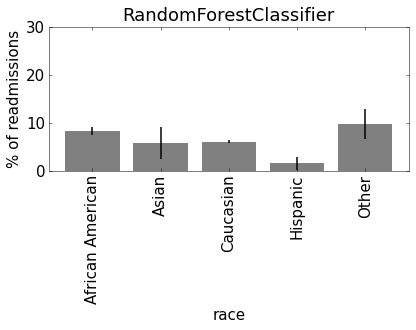

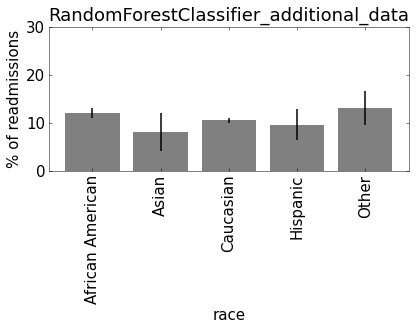

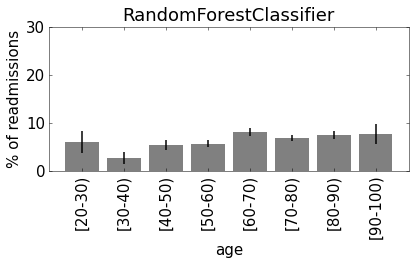

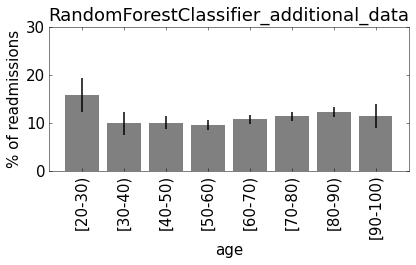

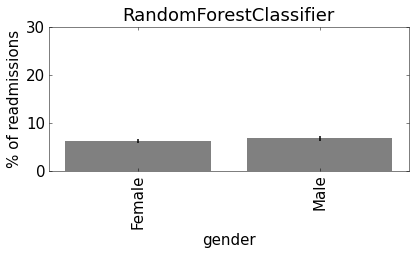

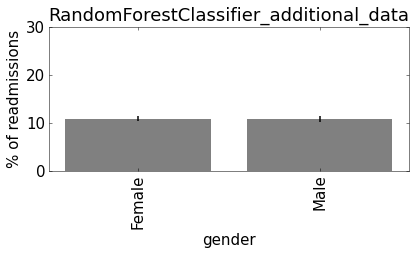

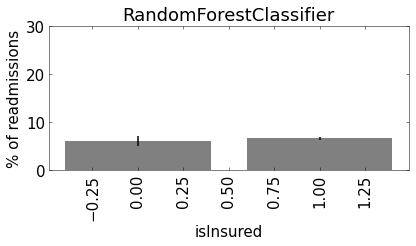

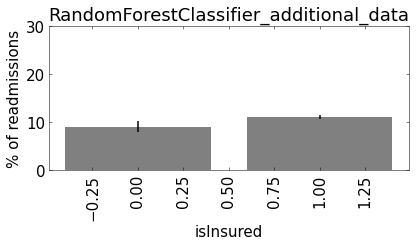

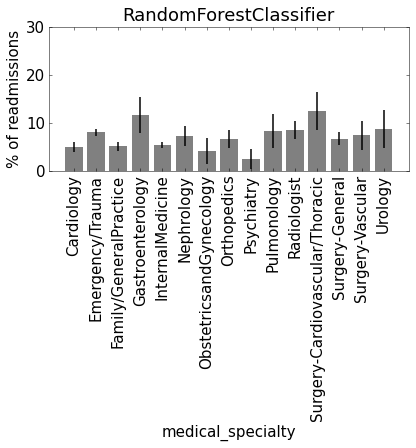

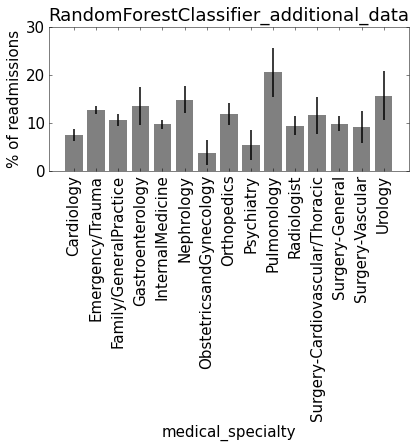

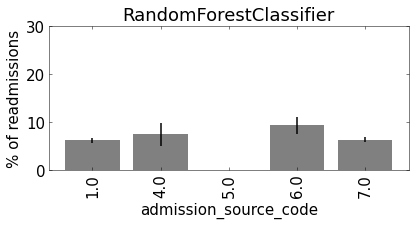

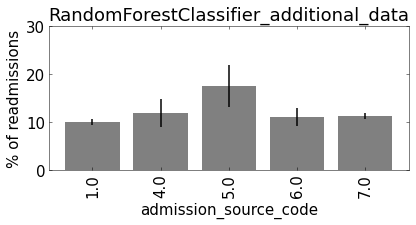

In [13]:

algorithms = ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC"]
#algorithms = ["RandomForestClassifier", "RandomForestClassifier_additional_data"]

for group in ["race", "age", "gender", "isInsured", "medical_specialty", "admission_source_code"]:

    best_subgroups = []
    worst_subgroups = []
    max_rates = []
    min_rates =[]

    for algorithm in algorithms:
        

        
        data_to_plot = check_for_bias(df_test, group,  "pred_proba_"+algorithm, 0.5, min_size=49)
        data_to_plot = data_to_plot.sort_values(by="sub_group")
        data_to_plot.readmittion_rate = data_to_plot.readmittion_rate*100
        fig, ax = plot_figure(5)

        sep = np.sqrt(list(data_to_plot["readmittion_rate"].values*(100- data_to_plot["readmittion_rate"].values)/(data_to_plot["size_of_test_data"].values)))
        ax.bar(data_to_plot["sub_group"], data_to_plot["readmittion_rate"].values, yerr = sep, color = bars_color)
        plt.xticks(rotation=90)
        plt.title(algorithm)

        ax.set_ylabel("% of readmissions")
        ax.set_xlabel(group)
        ax.set_ylim([0, 30])

        max_rate = max(data_to_plot.readmittion_rate)
        min_rate = min(data_to_plot.readmittion_rate)
        max_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == max_rate)].values[0]
        min_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == min_rate)].values[0]

        print(algorithm)
        print(max_rate_subgroup, max_rate)
        print(min_rate_subgroup, min_rate)
        print(max_rate-min_rate)
        print("#######")

        best_subgroups.append(min_rate_subgroup)
        worst_subgroups.append(max_rate_subgroup)
        max_rates.append(max_rate.round(2))
        min_rates.append(min_rate.round(2))

    df = pd.DataFrame([algorithms,worst_subgroups, max_rates,  best_subgroups, min_rates, [mx-mn for mx, mn in zip(max_rates, min_rates)]])
    df = df.transpose()
    df.columns = ["Classifier", "Group with highest rate", "Highest rate", "Group with lowest rate", "Lowest rate", "Difference"]
    df = df.set_index("Classifier", drop = True)
    dfi.export(df, group+"_table.png")
    #dfi.export(df, group+"_table_new_old.png")


In [ ]:

algorithms = ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC"]
features = ["race", "age", "gender", "isInsured", "medical_specialty"]
for algorithm in algorithms:

    best_subgroups = []
    worst_subgroups = []
    max_rates = []
    min_rates =[]

    for group in features:
        
        data_to_plot = check_for_bias(df_test, group,  "pred_proba_"+algorithm, 0.5, min_size=49)
        data_to_plot = data_to_plot.sort_values(by="sub_group")
        data_to_plot.readmittion_rate = data_to_plot.readmittion_rate*100

        max_rate = max(data_to_plot.readmittion_rate)
        min_rate = min(data_to_plot.readmittion_rate)
        max_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == max_rate)].values[0]
        min_rate_subgroup = data_to_plot.sub_group.iloc[np.where(data_to_plot.readmittion_rate == min_rate)].values[0]

        print(algorithm)
        print(max_rate_subgroup, max_rate)
        print(min_rate_subgroup, min_rate)
        print(max_rate-min_rate)
        print("#######")

        best_subgroups.append(min_rate_subgroup)
        worst_subgroups.append(max_rate_subgroup)
        max_rates.append(max_rate.round(2))
        min_rates.append(min_rate.round(2))

    df = pd.DataFrame([features,worst_subgroups, max_rates,  best_subgroups, min_rates, [mx-mn for mx, mn in zip(max_rates, min_rates)]])
    df = df.transpose()
    df.columns = ["Feature", "Group with highest rate", "Highest rate", "Group with lowest rate", "Lowest rate", "Difference"]
    df = df.set_index("Feature", drop = True)
    dfi.export(df, algorithm+"_table.png")


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


[0.52526524]
[0.19338648]
[0.48357327]


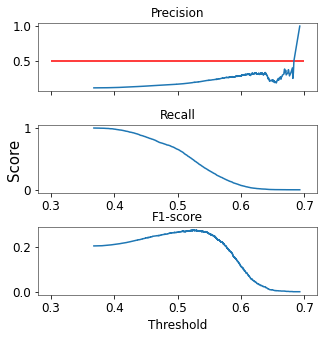

[0.52352589]
[0.19179856]
[0.49206349]


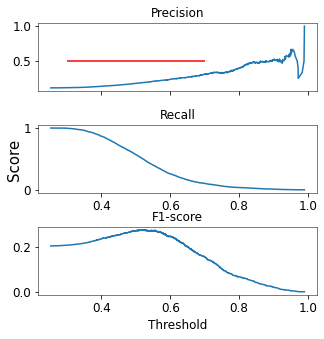

[0.55555556]
[0.18753727]
[0.464378]


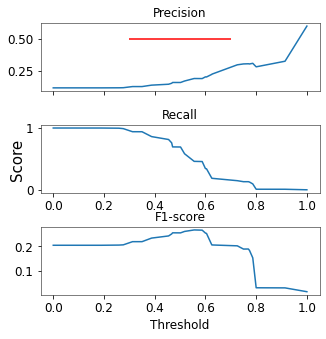

[0.52022898]
[0.18740592]
[0.55149502]


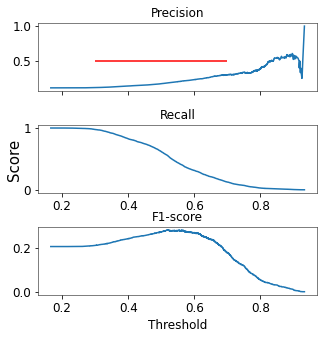

In [13]:
for algorithm in ["RandomForestClassifier", "LogisticRegression", "DecisionTreeClassifier", "GradientBoostingClassifier"]: #, "SVC"]:

    precision, recall, thresholds = precision_recall_curve(df_test.readmitted, df_test["pred_proba_"+algorithm])
    

    precision = precision[:-1]
    recall = recall[:-1]
    f1_score_result = 2*precision*recall/(precision+recall)
    
    if algorithm == "RandomForestClassifier":
        df_save = pd.DataFrame([precision, recall, f1_score_result, thresholds]).transpose()
        df_save.columns = ["precision", "recall", "f1-score", "threshold"]
        df_save.to_csv("data/rfc_threshold_plot.csv")

    fig, ax = plot_figure(fig_width=5, fig_height=5)
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    ax1.hlines(y=0.5,xmin=0.3, xmax=0.7, colors='red')
    ax1.plot(thresholds,precision)
    ax2.plot(thresholds,recall)
    ax3.plot(thresholds,f1_score_result)

    ax1.get_shared_x_axes().join(ax1, ax2, ax3)
    ax1.set_xticklabels([])
    plt.xlabel('Threshold', size=12)
    ax1.set_title('Precision', size=12)
    ax2.set_title('Recall', size=12)
    ax3.set_title('F1-score', size=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax3.tick_params(axis='both', which='major', labelsize=12)

    plt.subplots_adjust(hspace=0.5)
    fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical', size=15)


    print(thresholds[np.where(f1_score_result==max(f1_score_result))])
    print(precision[np.where(f1_score_result==max(f1_score_result))])
    print(recall[np.where(f1_score_result==max(f1_score_result))])



    plt.show()
    fig.savefig(f'{algorithm}_threshold.png', dpi=300, transparent=True, bbox_inches='tight')


                        Feature  Importance
16            blood_transfusion    0.003372
8            num_lab_procedures    0.006586
0                          race    0.010450
3    discharge_disposition_code    0.011760
9                num_procedures    0.012937
5              time_in_hospital    0.019146
7   complete_vaccination_status    0.033700
23                   age_as_int    0.085894
21                       change    0.211942
6                has_prosthesis    0.497100


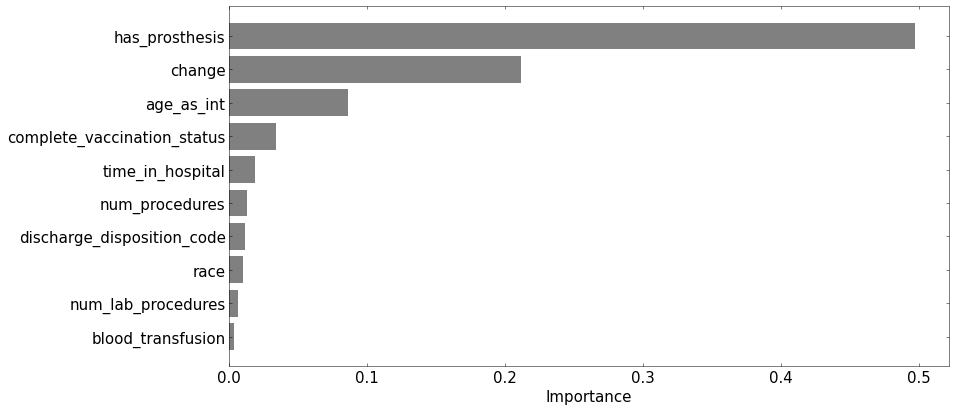

                        Feature  Importance
26            diag_3_simplified    0.021266
1                        gender    0.027391
9                num_procedures    0.032274
7   complete_vaccination_status    0.040896
0                          race    0.041557
3    discharge_disposition_code    0.048436
23                   age_as_int    0.071548
5              time_in_hospital    0.079643
21                       change    0.116407
6                has_prosthesis    0.231976


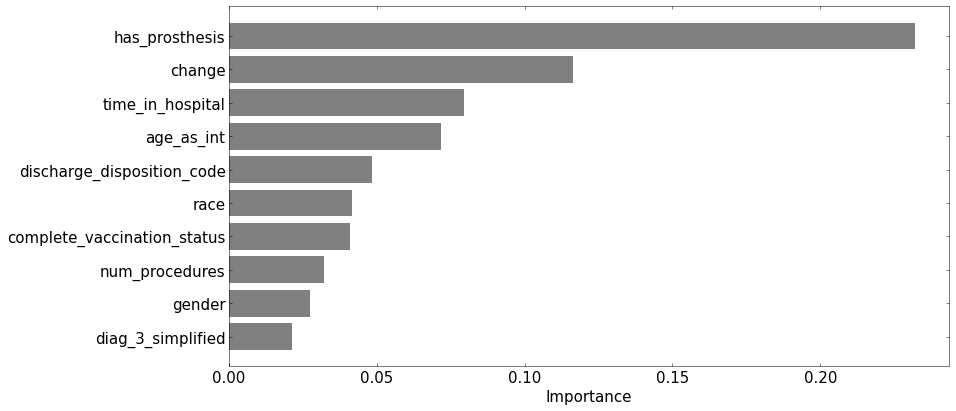

                        Feature  Importance
22                  diabetesMed    0.011998
1                        gender    0.025756
9                num_procedures    0.026333
7   complete_vaccination_status    0.029127
5              time_in_hospital    0.030957
8            num_lab_procedures    0.033896
23                   age_as_int    0.034622
3    discharge_disposition_code    0.047529
21                       change    0.121586
6                has_prosthesis    0.360875


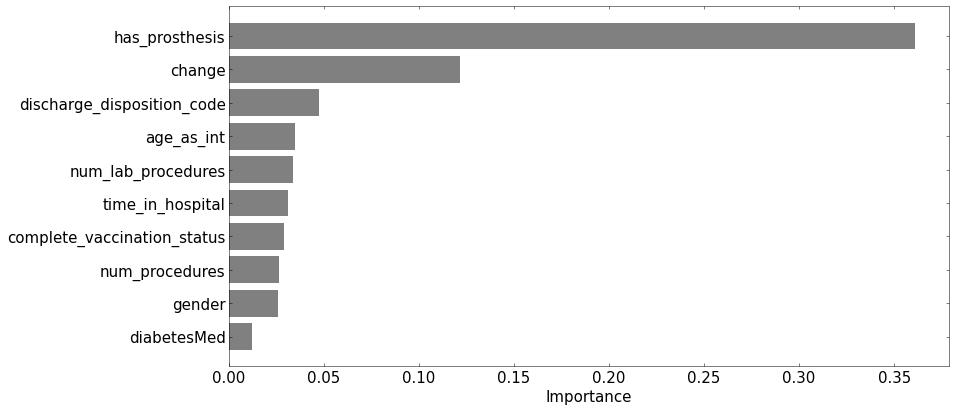

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [35]:
for algorithm in ["DecisionTreeClassifier", "RandomForestClassifier", "GradientBoostingClassifier", "SVC"]:

    # Create list of top most features based on importance
    pipeline = joblib.load(f"pipelines/pipeline_{algorithm}.pickle")

    feature_names = columns
    feature_importance = pipeline.named_steps['gridsearchcv'].best_estimator_.feature_importances_
    most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_importance)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
    most_imp_features.sort_values(by="Importance", inplace=True)
    print(most_imp_features)

    fig, ax = plot_figure(fig_width=10, fig_height=5)

    #plt.figure(figsize=(10,6))
    plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', color=bars_color)
    plt.yticks(range(len(most_imp_features)), most_imp_features.Feature)
    plt.xlabel('Importance')
    plt.show()
    fig.savefig(f'{algorithm}_feature_importance.png', dpi=300, transparent=True, bbox_inches='tight')
